In [1]:
from tool import *
import plotly.express as px
# import matplotlib.pyplot as plt

# 1. 특정 모델/특정 Site의 현재부터 이후 구간의 과거부터 현재까지의 물동 변동 이력 조회

In [106]:
interval = 20 # 금주 이후 몇주 동안의 변동을 조회할 지 설정
period = 20 # 과거 몇주 간의 변동을 조회할 지 설정
thisweek = get_weekname(datetime.date.today()) # 이번주의 Weekname 가져옴
ver = 'Latest' # Forecast 변동을 조회할 version 설정(Latest, Final, ODM Release)
model = r'14T90Q' # Forecast 변동을 조회할 모델 설정(.로 하면 모든 모델)
site = r'.' # 조회할 법인명(.로 하면 모든 법인)
forecast_period = [get_weekname_from(thisweek, i) for i in range(interval)] # forecast 변동을 보고 싶은 구간 설정
history_period = [get_weekname_from(thisweek, i) for i in range(-period, 0, 1)] # Forecast 변동 이력을 조회할 구간 설정

with open('D:/Data/GSCP raw data.bin', 'rb') as f:
    df = pickle.load(f)

df = df[df['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).replace(srt_model).str.contains(model)] # 조회할 모델로만 Sorting 함
# 데이터프레임 추출 조건 설정
c1 = df['Updated_at'].isin(df[['Ref', 'Ver', 'Updated_at']].drop_duplicates().groupby(['Ref', 'Ver'])['Updated_at'].max().unstack()[ver]) # 찾고자 하는 ver별의 가장 최근 update 된 시간으로 조회하기 위한 조건
c2 = (df['Ver'] == ver) # 조회할 Version 만 sorting 하기 위한 조건
c3 = df['Ref'].isin(history_period) # Forecast 변동 이력을 조회할 구간만 sorting 하기 위한 조건
c4 = df['To Site'].str.contains(site)

df = df[c1 & c2 & c3 & c4].groupby('Ref').sum()[forecast_period]
df = monthly_sum(df, 'Ref').stack().reset_index()
df.rename(columns={'level_1':'Month', 0:'QTY'}, inplace=True)
fig = px.bar(df, x='Ref', y='QTY', color='Month', width=500, height=400, title=f'{model} Variation History')
fig.update_xaxes(tickangle=70)
fig.show()

C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_3272\1257051669.py:20: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



# 2. 특정모델/특정Site의 과거 특정시점 이후 물동의 변동결과

In [104]:
starting_date = datetime.date(2023, 1, 3) # 조회 시작할 과거 특정일
startweek = get_weekname(starting_date) # 이번주의 Weekname 가져옴
# start_month = (starting_date.isocalendar().year, get_month_from_date(starting_date))
interval = 50 # 시작주 이후 몇주 동안의 변동을 조회할 지 설정
period = 15 # 미래 몇주 간의 변동을 조회할 지 설정
ver = 'Latest' # 물동 변동을 조회할 version 설정(Latest, Final, ODM Release)
model = r'14T90Q' # Forecast 변동을 조회할 모델 설정(.로 하면 모든 모델)
site = r'.' # 조회할 법인명(.로 하면 모든 법인)
target_period = [get_weekname_from(startweek, i) for i in range(interval)]
variation_period = [get_weekname_from(startweek, i) for i in range(period)]

with open('D:/Data/GSCP raw data.bin', 'rb') as f:
    df = pickle.load(f)

df = df[df['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).replace(srt_model).str.contains(model)] # 조회할 모델로만 Sorting 함

# 데이터프레임 추출 조건 설정
c1 = df['Updated_at'].isin(df[['Ref', 'Ver', 'Updated_at']].drop_duplicates().groupby(['Ref', 'Ver'])['Updated_at'].max().unstack()[ver]) # 찾고자 하는 ver별의 가장 최근 update 된 시간으로 조회하기 위한 조건
c2 = (df['Ver'] == ver) # 조회할 Version 만 sorting 하기 위한 조건
c3 = df['Ref'].isin(variation_period) # Forecast 변동 이력을 조회할 구간만 sorting 하기 위한 조건
c4 = df['To Site'].str.contains(site)

df = df[c1 & c2 & c3 & c4].groupby('Ref').sum()[target_period]
for wk in df.index:
    if (datetime.date.fromisoformat(wk[:10]).isocalendar().year, get_month_from_date(datetime.date.fromisoformat(wk[:10]))) >= (move_month(starting_date.isocalendar()[0], get_month_from_date(starting_date), 2)):
        df.loc[wk, startweek:get_weekname_from(get_weeklist_for_certain_month(get_lastmonth(wk)[0], get_lastmonth(wk)[1])[0], -1)] = df.loc[get_weekname_from(wk, -1), startweek:get_weekname_from(get_weeklist_for_certain_month(get_lastmonth(wk)[0], get_lastmonth(wk)[1])[0], -1)]
df = monthly_sum(df, 'Ref').stack().reset_index()
df.rename(columns={'level_1':'Month', 0:'QTY'}, inplace=True)
fig = px.bar(df, x='Ref', y='QTY', color='Month', width=500, height=400, title=f'{model} Variation History')
fig.update_xaxes(tickangle=70)
fig.show()

C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_3272\2950904878.py:23: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [86]:
df.pivot_table('QTY', index='Ref', columns='Month', aggfunc=sum)

Month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10
Ref,,,,,,,,,,
2023-01-02(W01),3872,1200,300,0,0,0,0,0,0,0
2023-01-09(W02),3872,1750,300,40,190,120,0,0,0,0
2023-01-16(W03),3872,1900,200,40,190,120,0,0,0,0
2023-01-23(W04),3772,1725,400,60,215,130,0,0,0,0
2023-01-30(W05),40,5447,225,190,215,190,84,0,0,0
2023-02-06(W06),40,5447,235,190,215,190,90,0,0,0
2023-02-13(W07),40,5447,435,170,210,100,0,0,0,0
2023-02-20(W08),40,5447,485,170,235,25,0,0,0,0
2023-02-27(W09),40,2644,3213,170,185,165,0,0,0,0


In [11]:
thisweek = get_weekname(datetime.date.today())
wklist = [get_weekname_from(thisweek, i) for i in range(-5, 1)]

In [12]:
# GSCP DB에서 ver, 업체명, 조회할주차, 조회할 모델을 주면 해당 SP의 변동 이력을 출력하는 함수
def get_sp_history(ver, vendor, search_week, search_model_list):
    sp_history = pd.DataFrame()
    for model in search_model_list:
        for week in wklist:
            sp = get_sp_from_GSCP_DB(week, ver, vendor)
            sp.insert(0, 'Ref', week)
            sp_history = pd.concat([sp_history, sp[sp['Mapping Model.Suffix'] == model]])
    return sp_history.fillna(0)

In [13]:
ver = 'Final'
vendor = 'Quanta'
search_models = ['15UG50P-G.AA7FKN', '15UG50P-G.AR3DKN', '15U50P-L.AR2BL']

In [14]:
history = get_sp_history(ver, vendor, wklist, search_models)

In [15]:
history.to_clipboard()

In [46]:
get_pdr().columns

Index(['Series', 'Model', 'Model.Suffix', 'Marketing Spec.', 'PDR No.',
       'Grade', 'Product Variance', 'Bar Code', 'Project Code',
       'PDR Description', 'BASE UNIT', 'MECHA ASSY', 'LCD ASSY',
       'WIRELESS LAN', 'KEYBOARD', 'BATTERY', 'PEN', 'ADAPTER', 'POWER CORD',
       'OS TYPE', 'OS LANGUAGE', 'LAN GENDER', 'MANUAL', 'WARRANTY',
       'ACCESSORY KIT', 'PACKING', 'EMERGING MARKET', 'OS DIGITAL KEY',
       '3.0 CPU LABEL', '1.0 ID LABEL', '12. WINDOWS LABEL', 'BAG', 'CUSTOMER',
       'USB MOUSE', 'MASTER', '1.1 MAIN BOARD', '1.2 SET COLOR',
       '2.4 DTS MARK', '1.4 HDMI MARK', '1.5 SET KCC INFORM',
       '1.6 MOUSE KCC INFORM', '2.6 PEN KCC INFORM', 'Revision', 'PDR Type',
       'Nation', 'Shipping Date', 'Affiliate Code', 'Production Type',
       'Customer Model', 'Disabled Status', 'Bill to Customer',
       'Producing Center', 'Model Description', 'Sales Model.Suffix',
       'Sales Affiliate Code', 'FINGER PRINT', 'SSD', 'SSD2', 'POUCH',
       'HDMI GENDER 

In [47]:
pdr = get_pdr()[['Model.Suffix', '1.2 SET COLOR']]
pdr = pdr.rename(columns={'Model.Suffix':'Mapping Model.Suffix', '1.2 SET COLOR':'COLOR'})
pdr

,Mapping Model.Suffix,COLOR
0,11TG50Q-C.AC10KN,GRAY
1,11TC50Q-E.AC11ML,GRAY
2,11TG50Q-E.AC10KN,GRAY
3,11TC50Q-E.AC10ML,GRAY
4,11TC50Q-E.AC10K,GRAY
...,...,...
561,16T90R-G.AP75A3,BLACK
562,16T90R-G.CD78C,BLACK
563,16T90R-K.AAC7U1,BLACK
564,16T90R-K.AAC8U1,BLACK


In [50]:
history.merge(pdr).to_clipboard()

In [2]:
# general options
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',30)

In [9]:
get_difference_table(sp1, sp2, '-\d\d').sum()

2022-10-03(W40)       0
2022-10-10(W41)       0
2022-10-17(W42)       0
2022-10-24(W43)       0
2022-10-31(W44)    1010
                   ... 
2023-10-09(W41)       0
2023-10-16(W42)       0
2023-10-23(W43)       0
2023-10-30(W44)       0
2023-11-06(W45)       0
Length: 58, dtype: int64

In [4]:
today = datetime.date(2022, 11, 7)
sp1_week = get_weekname(today)
sp2_week = get_weekname_from(sp1_week, 0)
sp1_ver = 'Final'
sp2_ver = 'ODM Release'
vendor = 'Quanta'
print(f'1. 기준이 되는 SP는 {vendor}의 {sp1_week} 주차의 {sp1_ver} 버전')
print(f'2. 비교할 대상 SP는 {vendor}의 {sp2_week} 주차의 {sp2_ver} 버전')

sp1 = get_sp_from_GSCP_DB(sp1_week, sp1_ver, vendor)
sp2 = get_sp_from_GSCP_DB(sp2_week, sp2_ver, vendor)
if vendor == 'Wanlida':
    mon_sum = category_sum(get_difference_table(sp1, sp2, '-\d\d').reset_index().rename(columns={'level_0':'Mapping Model.Suffix'}).groupby('Mapping Model.Suffix').sum())
else:
    mon_sum = category_sum(get_difference_table(sp1, sp2, '-\d\d').reset_index().rename(columns={'level_0':'Series'}).groupby('Series').sum())
mon_sum.loc['Total'] = mon_sum.sum()
start_col = category_sum(sp1).columns[0]
end_col = mon_sum.loc[:, mon_sum.sum() != 0].columns.max()
mon_sum = mon_sum.loc[:, start_col:end_col]
mon_sum.loc[:, 'Total'] = mon_sum.sum(axis=1)
mon_sum

1. 기준이 되는 SP는 Quanta의 2022-11-07(W45) 주차의 Final 버전
2. 비교할 대상 SP는 Quanta의 2022-11-07(W45) 주차의 ODM Release 버전


TypeError: cannot do slice indexing on Index with these indexers [nan] of type float

In [12]:
name = '11T50Q'
vendor = 'Quanta'
ver = 'Final'

df = make_forecast_change_for_certain_model(-1, 4, name, ver, vendor)
df.loc[:, 'Total'] = df.sum(axis=1)
end_value = df[df['Total'] != 0].index.max()
df = df.loc[:end_value, :].drop(columns='Total')
df['Sum'] = df.sum(axis=1)
df.loc['Sum'] = df.sum()
df = df.convert_dtypes()
df

,2022-11-07(W45),2022-10-31(W44),2022-10-24(W43),2022-10-17(W42),Sum
2022-10,43.0,43.0,43.0,43.0,172
2022-11,600.0,600.0,0.0,0.0,1200
2022-12,320.0,260.0,220.0,190.0,990
2023-01,230.0,230.0,230.0,270.0,960
2023-02,200.0,200.0,200.0,160.0,760
2023-03,120.0,120.0,120.0,120.0,480
Sum,1513.0,1453.0,813.0,783.0,4562


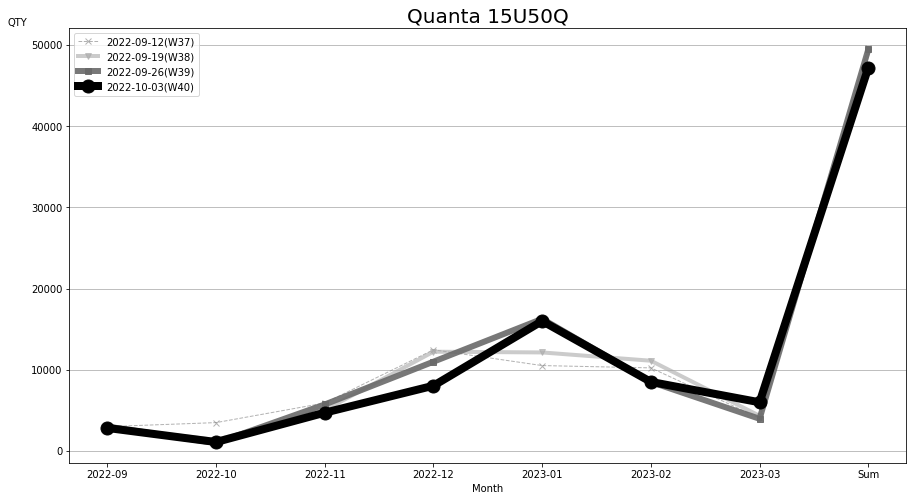

In [6]:
plot_forecast_change(df, f'{vendor} {name}')

In [7]:
wklist = get_weeklist_for_certain_month(2023, 1) + get_weeklist_for_certain_month(2023, 2)
wklist = wklist[:-1]
wklist

['2023-01-02(W01)',
 '2023-01-09(W02)',
 '2023-01-16(W03)',
 '2023-01-23(W04)',
 '2023-01-30(W05)',
 '2023-02-06(W06)',
 '2023-02-13(W07)']

In [10]:
sp_all = pd.DataFrame()
for wk in wklist:
    sp = get_sp_from_GSCP_DB(wk, 'Latest', 'Quanta')
    sp['Ref'] = wk
    sp_all = pd.concat([sp_all, sp])
sp_all

,Series,Mapping Model.Suffix,Region,Country,To Site,2022-11-28(W48),2022-12-05(W49),2022-12-12(W50),2022-12-19(W51),2022-12-26(W52),...,2023-12-11(W50),2023-12-18(W51),2023-12-25(W52),2024-01-01(W01),2024-01-08(W02),2024-01-15(W03),2024-01-22(W04),2024-01-29(W05),2024-02-05(W06),Ref
0,11T50Q,11TG50Q-C.AC10KN,KOREA,Korea,EKHQ,0,0,0,0,7,...,0,0,0,0,0,0,0,0,0,2023-01-02(W01)
1,11T50Q,11TG50Q-E.AC10KN,KOREA,Korea,EKHQ,0,0,120,576,0,...,0,0,0,0,0,0,0,0,0,2023-01-02(W01)
2,14T90P,14T90P-G.ARTGK,KOREA,Korea,EKHQ,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023-01-02(W01)
3,14T90Q,14T90Q-G.AA55A3,SEA,Singapore,EASL,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,2023-01-02(W01)
4,14T90Q,14T90Q-G.AA55Y,EU,Poland,EEPL,0,0,20,0,0,...,0,0,0,0,0,0,0,0,0,2023-01-02(W01)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,16T90Q,16TD90Q-G.AX70K,KOREA,Korea,EKHQ,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,2023-02-13(W07)
141,16T90R,16TD90R-G.AX56K,KOREA,Korea,EKHQ,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,2023-02-13(W07)
142,16T90R,16TD90R-G.AX76K,KOREA,Korea,EKHQ,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,2023-02-13(W07)
143,16T90Q,16TG90Q-G.AA75KN,KOREA,Korea,EKHQ,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,2023-02-13(W07)


In [14]:
sp_all[sp_all['Mapping Model.Suffix'] == '16T90R-G.AA5CK'].to_clipboard()

### Quanta Forecast

In [3]:
with open('D:/Data/Quanta forecast.bin', 'rb') as f:
    df = pickle.load(f)

In [4]:
df = df[df['Series'] == '11T50Q']

In [34]:
df = df[df['Mapping Model.Suffix'] == '11TG50Q-E.AC10KN']

In [5]:
df.groupby(['Ref_week', 'Mapping Model.Suffix']).sum().to_excel('d:/Python result/a.xlsx')

In [30]:
df = df.groupby(['Ref_week', 'Mapping Model.Suffix']).sum().stack().reset_index()
df.rename(columns={'level_2':'Week', 0:'QTY'}, inplace=True)
df

,Ref_week,Mapping Model.Suffix,Week,QTY
0,2022-01-03(W01),11TG50Q-E.AC10KN,2021-11-29(W48),0
1,2022-01-03(W01),11TG50Q-E.AC10KN,2021-12-06(W49),7
2,2022-01-03(W01),11TG50Q-E.AC10KN,2021-12-13(W50),0
3,2022-01-03(W01),11TG50Q-E.AC10KN,2021-12-20(W51),0
4,2022-01-03(W01),11TG50Q-E.AC10KN,2021-12-27(W52),0
...,...,...,...,...
1363,2022-06-13(W24),11TG50Q-E.AC10KN,2022-11-28(W48),100
1364,2022-06-13(W24),11TG50Q-E.AC10KN,2022-12-05(W49),95
1365,2022-06-13(W24),11TG50Q-E.AC10KN,2022-12-12(W50),100
1366,2022-06-13(W24),11TG50Q-E.AC10KN,2022-12-19(W51),100


In [4]:
df = category_sum(df.groupby(['Ref_week', 'Series']).sum())

In [5]:
df = df.stack().reset_index()
df.rename(columns={'level_2':'Month'})

,Ref_week,Series,Month,0
0,2022-01-03(W01),11T50Q,2021-12,7
1,2022-01-03(W01),11T50Q,2022-01,350
2,2022-01-03(W01),11T50Q,2022-02,1970
3,2022-01-03(W01),11T50Q,2022-03,950
4,2022-01-03(W01),11T50Q,2022-04,0
...,...,...,...,...
3401,2022-06-13(W24),16T90Q,2022-08,3145
3402,2022-06-13(W24),16T90Q,2022-09,7675
3403,2022-06-13(W24),16T90Q,2022-10,9530
3404,2022-06-13(W24),16T90Q,2022-11,6725


In [6]:
df = df.rename(columns={'level_2':'Month'})

In [7]:
df = df.rename(columns={0:'QTY'})

In [24]:
import seaborn as sns

In [10]:
cond2 = df['Ref_week'].isin(df['Ref_week'].unique()[-4:])

<AxesSubplot:xlabel='Week', ylabel='QTY'>

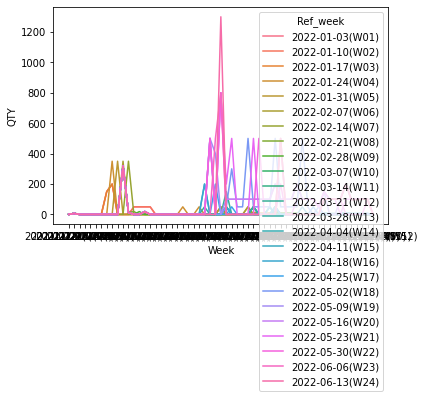

In [31]:
sns.lineplot(x='Week', y='QTY', data=df, hue='Ref_week')

In [6]:
df = df.groupby(['Ref_week','Series', 'Region', 'To Site', 'Model.Suffix']).sum()
df

2021-11-29(W48)  \
Ref_week        Series Region To Site  Model.Suffix                        
2022-01-03(W01) 11T50Q KOREA  EKHQ     11TC50Q-E.AC10K                 0   
                                       11TG50Q-E.AC10KN                0   
                14T90P CHINA  ECNT_P   14T90P-G.AA54C                  0   
                                       14T90P-G.AA77C                  0   
                       EU     EEES     14T90P-G.AA78B                  0   
...                                                                  ...   
2022-06-06(W23) 16T90Q SEA    EHAP_LGS 16T90Q-G.AA55A                  0   
                                       16T90Q-G.AA75A                  0   
                                       16T90Q-G.AA78A                  0   
                              EJJP     16T90Q-K.AA75J                  0   
                                       16T90Q-K.AA78J                  0   

                                                         2021-12-06(W49)  \
Ref_week        Series Region To Site  Model.Suffix                        
2022-01-03(W01) 11T50Q KOREA  EKHQ     11TC50Q-E.AC10K                 0   
                                       11TG50Q-E.AC10KN                7   
                14T90P CHINA  ECNT_P   14T90P-G.AA54C                  0   
                                       14T90P-G.AA77C                  0   
                       EU     EEES     14T90P-G.AA78B                  0   
...                                                                  ...   
2022-06-06(W23) 16T90Q SEA    EHAP_LGS 16T90Q-G.AA55A                  0   
                                       16T90Q-G.AA75A                  0   
                                       16T90Q-G.AA78A                  0   
                              EJJP     16T90Q-K.AA75J                  0   
                                       16T90Q-K.AA78J                  0   

                                                         2021-12-13(W50)  \
Ref_week        Series Region To Site  Model.Suffix                        
2022-01-03(W01) 11T50Q KOREA  EKHQ     11TC50Q-E.AC10K                 0   
                                       11TG50Q-E.AC10KN                0   
                14T90P CHINA  ECNT_P   14T90P-G.AA54C                  0   
                                       14T90P-G.AA77C                  0   
                       EU     EEES     14T90P-G.AA78B                  0   
...                                                                  ...   
2022-06-06(W23) 16T90Q SEA    EHAP_LGS 16T90Q-G.AA55A                  0   
                                       16T90Q-G.AA75A                  0   
                                       16T90Q-G.AA78A                  0   
                              EJJP     16T90Q-K.AA75J                  0   
                                       16T90Q-K.AA78J                  0   

                                                         2021-12-20(W51)  \
Ref_week        Series Region To Site  Model.Suffix                        
2022-01-03(W01) 11T50Q KOREA  EKHQ     11TC50Q-E.AC10K                 0   
                                       11TG50Q-E.AC10KN                0   
                14T90P CHINA  ECNT_P   14T90P-G.AA54C                  0   
                                       14T90P-G.AA77C                  0   
                       EU     EEES     14T90P-G.AA78B                  0   
...                                                                  ...   
2022-06-06(W23) 16T90Q SEA    EHAP_LGS 16T90Q-G.AA55A                  0   
                                       16T90Q-G.AA75A                  0   
                                       16T90Q-G.AA78A                  0   
                              EJJP     16T90Q-K.AA75J                  0   
                                       16T90Q-K.AA78J                  0   

                                                         2021-12-27(W52)  \
Ref_week        Series Re

In [7]:
df = df.reset_index()

In [9]:
cond1 = (df['Series'] == '15U50Q')

In [10]:
df[cond1]

,Ref_week,Series,Region,To Site,Model.Suffix,2021-11-29(W48),2021-12-06(W49),2021-12-13(W50),2021-12-20(W51),2021-12-27(W52),2022-01-03(W01),2022-01-10(W02),2022-01-17(W03),2022-01-24(W04),2022-01-31(W05),2022-02-07(W06),2022-02-14(W07),2022-02-21(W08),2022-02-28(W09),2022-03-07(W10),2022-03-14(W11),2022-03-21(W12),2022-03-28(W13),2022-04-04(W14),2022-04-11(W15),2022-04-18(W16),2022-04-25(W17),2022-05-02(W18),2022-05-09(W19),2022-05-16(W20),2022-05-23(W21),2022-05-30(W22),2022-06-06(W23),2022-06-13(W24),2022-06-20(W25),2022-06-27(W26),2022-07-04(W27),2022-07-11(W28),2022-07-18(W29),2022-07-25(W30),2022-08-01(W31),2022-08-08(W32),2022-08-15(W33),2022-08-22(W34),2022-08-29(W35),2022-09-05(W36),2022-09-12(W37),2022-09-19(W38),2022-09-26(W39),2022-10-03(W40),2022-10-10(W41),2022-10-17(W42),2022-10-24(W43),2022-10-31(W44),2022-11-07(W45),2022-11-14(W46),2022-11-21(W47),2022-11-28(W48),2022-12-05(W49),2022-12-12(W50),2022-12-19(W51),2022-12-26(W52)
283,2022-01-10(W02),15U50Q,KOREA,EKHQ,15U50Q,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4700,0,0,0,6700,0,0,0,0,8300,0,0,0,9500,0,0,0,9500,0,0,0,8500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
646,2022-01-24(W04),15U50Q,KOREA,EKHQ,15U50Q-G.AA3IK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,200,100,100,0,100,0,100,0,100,0,100,0,100,0,0,100,0,0,16,36,36,74,38,38,38,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0
647,2022-01-24(W04),15U50Q,KOREA,EKHQ,15U50Q-G.AA56K,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,100,0,0,0,0,100,0,0,0,0,0,0,0,26,16,15,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0
648,2022-01-24(W04),15U50Q,KOREA,EKHQ,15U50Q-G.AA5IK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,600,300,200,0,300,300,300,200,200,200,200,100,100,100,100,100,90,128,128,128,128,261,135,134,132,132,0,0,0,0,0,0,0,0,0,0,0,0,0,0
649,2022-01-24(W04),15U50Q,KOREA,EKHQ,15U50Q-G.AR30K,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,400,200,200,0,200,200,200,200,100,100,100,100,100,100,0,100,0,54,74,74,72,148,77,76,76,75,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,2022-06-06(W23),15U50Q,KOREA,EKHQ,15U50Q-G.AR50K,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,0,0,75,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,50,0,0,0,0,0
4845,2022-06-06(W23),15U50Q,KOREA,EKHQ,15U50Q-G.AR50ML,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4846,2022-06-06(W23),15U50Q,KOREA,EKHQ,15U50Q-G.AS50ML,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4847,2022-06-06(W23),15U50Q,KOREA,EKHQ,15UD50Q-G.AX30K,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,200,0,0,100,50,100,50,0,100,50,100,150,50,100,50,50,150,50,50,50,150,0,0,20,80,0


In [4]:
df_sum = monthly_sum(df, ['Ref_week', 'Series', 'Nation', 'Model.Suffix'])

In [5]:
df_sum['Sum'] = df_sum.sum(axis=1)
df_sum.to_excel('D:/Python result/Quanta Forecast waterfall.xlsx', merge_cells=False)

### Pegatron Forecast

In [3]:
thisweek = get_weekname(datetime.date.today())

In [4]:
with open('D:/Data/Pegatron forecast.bin', 'rb') as f:
    df = pickle.load(f)

In [29]:
df_sum = monthly_sum(df, ['Ref_week', 'Series', 'Nation'])
df_sum['Sum'] = df_sum.sum(axis=1)

In [30]:
df_sum.to_excel('D:/Python result/Pegatron Forecast waterfall.xlsx', merge_cells=False)

In [28]:
with open('D:/Data/Pegatron forecast.bin', 'wb') as f:
    pickle.dump(df, f)